In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
import pickle

In [ ]:


from src.utils.logger import Logging
from src.poisson.dv_solver import DVPDESolver
from src.poisson.cv_solver import CVPDESolver
from src.nn.pde import diffusion_operator
from src.utils.plot_prediction import plt_prediction
from src.data.diffusion_dataset import u, r
import src.poisson.diffusion_train as diffusion_train
from src.poisson.classical_solver import Classical_Solver
from src.data.diffusion_dataset import Sampler
from src.utils.cavity_plot_contour import ContourPlotter


os.environ['CUDA_VISIBLE_DEVICES'] = '-1'    # for no GPUs


In [34]:

DEVICE = "cpu"

mode = "hybrid"
num_qubits = 5
output_dim = 1
input_dim = 3
hidden_dim = 50
num_quantum_layers = 1
cutoff_dim = 10
classic_network = [input_dim, hidden_dim, output_dim]



args = {
    "batch_size": 64,
    "epochs": 20000,
    "lr": 0.0001,
    "seed": 1,
    "print_every": 5000,
    "log_path": "./checkpoints/helmholtz",
    "input_dim": input_dim,
    "output_dim": output_dim,
    "num_qubits": num_qubits,
    "hidden_dim": hidden_dim,
    "num_quantum_layers": num_quantum_layers,
    "classic_network": classic_network,
    "q_ansatz": "sim_circ_19",  # options: "alternating_layer_tdcnot", "abbas" , farhi , sim_circ_13_half, sim_circ_13 , sim_circ_14_half, sim_circ_14 , sim_circ_15 ,sim_circ_19
    "mode": mode,
    "activation": "tanh",  # options: "null", "partial_measurement_half" , partial_measurement_x
    "shots": None,  # Analytical gradients enabled
    "problem": "helmholtz",
    "solver": "Classical",  # options : "CV", "Classical", "DV"
    "device": DEVICE,
    "method": "None",
    "cutoff_dim": cutoff_dim,  # num_qubits >= cutoff_dim
    "class": "Classical",  # options : "DVQuantumLayer", GSRandomCVQNN , "CVQuantumLayer", "Enhanced_CVQuantumLayer"
    "encoding": "Classical", # options angle , amplitude
}



In [5]:
log_path = args["log_path"]
logger = Logging(log_path)

In [85]:

if args["solver"] == "CV":
    model = CVPDESolver(args, logger, DEVICE)
    model.logger.print("Using CV Solver")
elif args["solver"] == "Classical":
    model = Classical_Solver(args, logger, DEVICE)
    model.logger.print("Using Classical Solver")
else:
    model = DVPDESolver(args, logger, DEVICE)
    model.logger.print("Using DV Solver")
# Training loop
model.logger.print(f"The settings used:")
for key, value in args.items():
    model.logger.print(f"{key} : {value}")



INFO:src.utils.logger:checkpoint path: self.log_path='./checkpoints/helmholtz/2025-02-20_20-34-31-602927'
INFO:src.utils.logger:Using Classical Solver
INFO:src.utils.logger:The settings used:
INFO:src.utils.logger:batch_size : 64
INFO:src.utils.logger:epochs : 20000
INFO:src.utils.logger:lr : 0.0001
INFO:src.utils.logger:seed : 1
INFO:src.utils.logger:print_every : 5000
INFO:src.utils.logger:log_path : ./checkpoints/helmholtz
INFO:src.utils.logger:input_dim : 3
INFO:src.utils.logger:output_dim : 1
INFO:src.utils.logger:num_qubits : 5
INFO:src.utils.logger:hidden_dim : 50
INFO:src.utils.logger:num_quantum_layers : 1
INFO:src.utils.logger:classic_network : [3, 50, 1]
INFO:src.utils.logger:q_ansatz : sim_circ_19
INFO:src.utils.logger:mode : hybrid
INFO:src.utils.logger:activation : tanh
INFO:src.utils.logger:shots : None
INFO:src.utils.logger:problem : helmholtz
INFO:src.utils.logger:solver : Classical
INFO:src.utils.logger:device : cpu
INFO:src.utils.logger:method : None
INFO:src.utils.l

In [86]:
diffusion_train.train(model)


INFO:src.utils.logger:It: 0, Loss: 3.76e+00, Loss_res: 1.86e+00,  Loss_bcs: 4.58e-03, loss_ics: 8.20e-03, lr: 5.00e-03, Time: 3.74e-03
INFO:src.utils.logger:Model state saved to ./checkpoints/helmholtz/2025-02-20_20-34-31-602927/model.pth


INFO:src.utils.logger:It: 5000, Loss: 1.96e-01, Loss_res: 9.63e-02,  Loss_bcs: 4.57e-04, loss_ics: 8.47e-04, lr: 5.00e-03, Time: 2.72e-03
INFO:src.utils.logger:Model state saved to ./checkpoints/helmholtz/2025-02-20_20-34-31-602927/model.pth
INFO:src.utils.logger:It: 10000, Loss: 8.55e-02, Loss_res: 4.20e-02,  Loss_bcs: 1.06e-04, loss_ics: 4.92e-04, lr: 5.00e-03, Time: 3.56e-03
INFO:src.utils.logger:Model state saved to ./checkpoints/helmholtz/2025-02-20_20-34-31-602927/model.pth
INFO:src.utils.logger:It: 15000, Loss: 5.15e-02, Loss_res: 2.51e-02,  Loss_bcs: 8.43e-05, loss_ics: 4.97e-04, lr: 3.65e-03, Time: 3.85e-03
INFO:src.utils.logger:Model state saved to ./checkpoints/helmholtz/2025-02-20_20-34-31-602927/model.pth
INFO:src.utils.logger:It: 20000, Loss: 2.48e-02, Loss_res: 1.13e-02,  Loss_bcs: 4.61e-05, loss_ics: 9.85e-04, lr: 2.66e-03, Time: 3.43e-03
INFO:src.utils.logger:Model state saved to ./checkpoints/helmholtz/2025-02-20_20-34-31-602927/model.pth


In [90]:

# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")


INFO:src.utils.logger:Total number of parameters: 2801


## Plot loss history

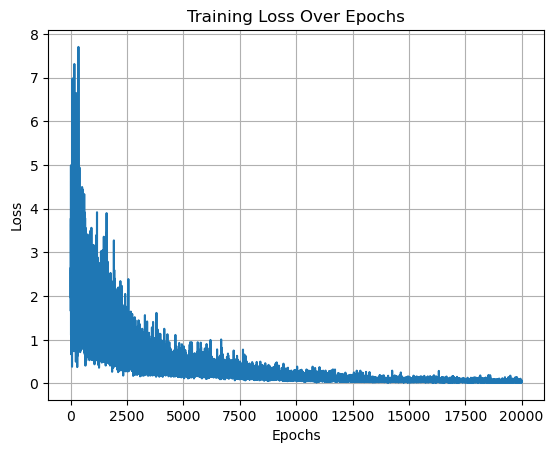

INFO:src.utils.logger:The last loss is: , 0.02480979822576046


In [ ]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

model.logger.print(f"The last loss is: , {model.loss_history[-1]}")


# Testing


In [88]:
NUM_OF_POINTS = 20

dom_coords = torch.tensor(
    [[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]], dtype=torch.float32, device="cpu"
)

time_ = (
    torch.linspace(dom_coords[0, 0], dom_coords[1, 0], NUM_OF_POINTS)
    .to("cpu")
    .unsqueeze(1)
    .to(torch.float32)
)
xfa = (
    torch.linspace(dom_coords[0, 1], dom_coords[1, 1], NUM_OF_POINTS)
    .to("cpu")
    .unsqueeze(1)
    .to(torch.float32)
)

yfa = (
    torch.linspace(dom_coords[0, 2], dom_coords[1, 2], NUM_OF_POINTS)
    .to("cpu")
    .unsqueeze(1)
    .to(torch.float32)
)

time_, xfa, yfa = torch.meshgrid(time_.squeeze(), xfa.squeeze(), yfa.squeeze())
X_star = torch.hstack(
    (
        time_.flatten().unsqueeze(1),
        xfa.flatten().unsqueeze(1),
        yfa.flatten().unsqueeze(1),
    )
).to("cpu")



In [89]:

u_pred, f_pred = diffusion_operator(
    model, X_star[:, 0:1], X_star[:, 1:2], X_star[:, 2:3]
)
if u_pred.is_cuda:
    u_pred = u_pred.cpu()
    f_pred = f_pred.cpu()


u_pred = u_pred.detach().numpy()
f_pred = f_pred.detach().numpy()

# Exact solution
u_analytic = u(X_star).cpu().detach().numpy()
f_analytic = r(X_star).cpu().detach().numpy()

error_u = (
    np.linalg.norm(u_analytic - u_pred, 2) / np.linalg.norm(u_analytic, 2)
) * 100.0
error_f = (
    np.linalg.norm(f_analytic - f_pred, 2) / np.linalg.norm(f_analytic + 1e-9, 2)
) * 100.0

logger.print("Relative L2 error_u: {:.2e}".format(error_u))
logger.print("Relative L2 error_f: {:.2e}".format(error_f))


INFO:src.utils.logger:Relative L2 error_u: 2.06e+01
INFO:src.utils.logger:Relative L2 error_f: 1.31e+01


In [58]:
tstep = NUM_OF_POINTS
xstep = NUM_OF_POINTS
ystep = NUM_OF_POINTS


X = X_star.cpu().detach().numpy()
exact_velocity = u_analytic
exact_force = f_analytic


xf = xfa.reshape(tstep, xstep, ystep).cpu().detach().numpy()  # .reshape(100,100)[0,:]
yf = yfa.reshape(tstep, xstep, ystep).cpu().detach().numpy()  # .reshape(100,100)[:,0]

exact_velocity = exact_velocity.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
exact_force = exact_force.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]

grbf_velocity = u_pred.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
grbf_force = f_pred.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]


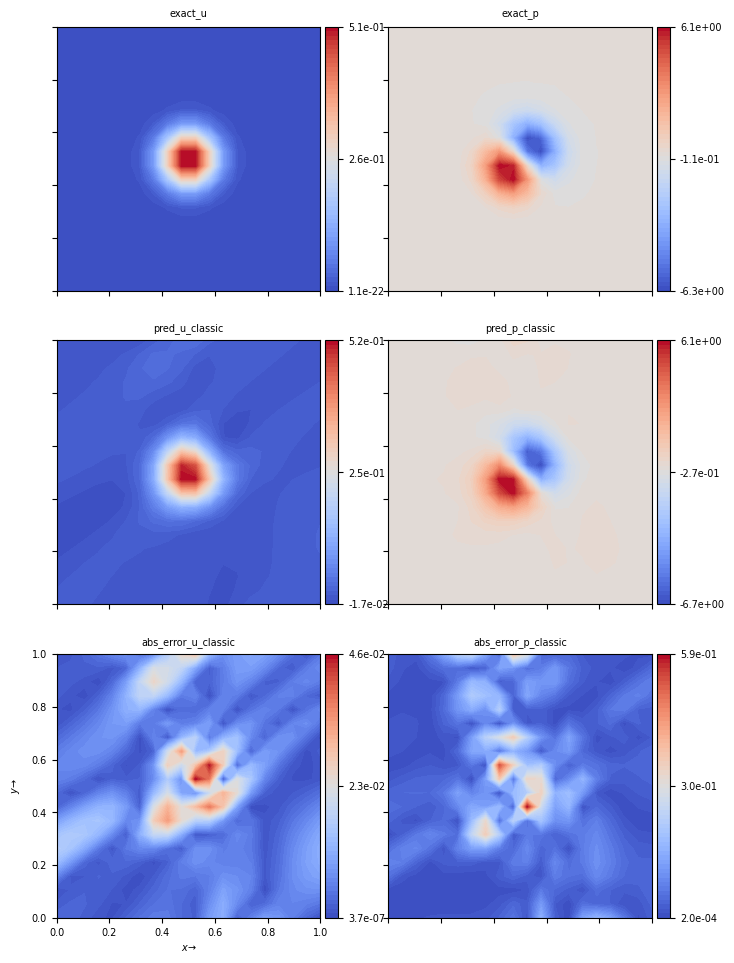

In [41]:

# Visualize results
titles = [
    "exact_u",
    "exact_p",
    "pred_u_classic",
    "pred_p_classic",
"abs_error_u_classic",
    "abs_error_p_classic",

]

nrows_ncols = (3, 2)
values = [99]
xref = 1
yref = 1
model_dirname = model.log_path
img_width = 10
img_height = 10
ticks = 3
fontsize = 7
labelsize = 7
axes_pad = 0.5

visualization_data = [
   exact_velocity,                  # exact_u
    exact_force,                  # exact_p
    grbf_velocity,              # u_pred_classic
    grbf_force,              # p_pred_classic
    np.abs(exact_velocity - grbf_velocity),        # error_u_classic
     np.abs(exact_force - grbf_force),        # error_p_classic
]

plotter = ContourPlotter(fontsize=7, labelsize=7, axes_pad=0.5)

plotter.draw_contourf_regular_2D(
    time_[:, 0, 0],
    xf[0, :, 0],
    yf[0, 0, :],
    visualization_data,
    titles=titles,
    nrows_ncols=nrows_ncols,
    time_steps=[10],
    xref=1,
    yref=1,
    model_dirname=model_dirname,
    img_width=10,
    img_height=10,
    ticks=3,    
)
